In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from config import TREATMENT, OUTCOME
from modules.data_generation import (
    DataGeneration,
    add_synthetic_features
)
from utils.linear_regression import build_sm_regression_formula

In [6]:
n_samples = 15000
percentiles = np.arange(0, 1, 0.1)


confounders = [
    'years_since_default',
    'default_debt_amount',
    'n_consumo',
    'debt_cirbe',
    'n_tarjeta'
]

In [7]:
generator = DataGeneration()
df = generator.generate_random_financial_data(n_samples)
generator.fit_scalers(df)
df[TREATMENT] = generator.generate_treatment(df, noise=True, noise_scale=0.1, treament_noise_std=10)
df[OUTCOME + "_probs"] = generator.calculate_outcome_probability(df, df[TREATMENT])
df[OUTCOME]  = np.random.binomial(n=1, p=df[OUTCOME + "_probs"])
df = add_synthetic_features(df, n_redundant=30, n_noise=100)

c:\Users\xavim\Documents\causal_inference\causal_paper\modules\data_generation.py:329: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'noise*feature*{i+1}'] = noise
c:\Users\xavim\Documents\causal_inference\causal_paper\modules\data_generation.py:329: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'noise*feature*{i+1}'] = noise
c:\Users\xavim\Documents\causal_inference\causal_paper\modules\data_generation.py:329: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [ ]:
# understand the new noise addition

import pandas as pd
import numpy as np

from scipy import stats


treatment_raw = np.array([17, 43, 80, 91, 22, 5, 17, 43, 80, 91, 22, 5, 17, 43, 80, 91, 22, 5])
scale = 10

treatment_noisy = np.zeros_like(treatment_raw)
for i, base_value in enumerate(treatment_raw):
    # Lower/upper bounds in "Z-space"
    a = (0    - base_value) / scale
    b = (100  - base_value) / scale
    print(base_value, a, b, stats.truncnorm.rvs(a, b, loc=base_value, scale=scale))
    # Draw from truncated normal
    treatment_noisy[i] = stats.truncnorm.rvs(a, b, loc=base_value, scale=scale)

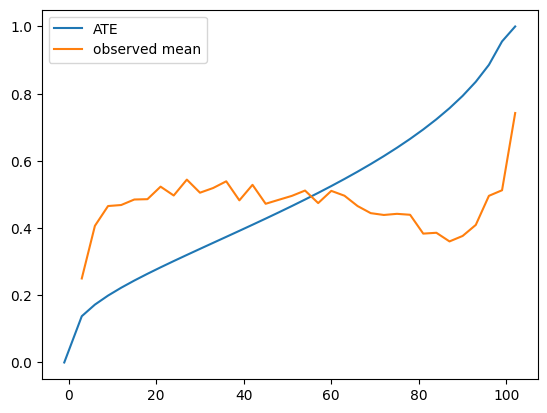

In [9]:
step = 3
bin_edges = np.arange(0, 100+step, step)
ate_causal_effect = generator.compute_causal_effects(df, bin_edges, "ate")
bin_edges[0] = -1
intervals = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]
df['treatment_bin'] = pd.cut(df[TREATMENT], bins=bin_edges, labels=False)

mean_outcome = [c[0] for c in df.groupby(['treatment_bin'])[[OUTCOME]].mean().to_numpy().tolist()]
plt.plot(bin_edges, ate_causal_effect, label="ATE")
plt.plot(bin_edges[1:], mean_outcome, label="observed mean")
plt.legend(loc="upper left")
plt.show()

In [10]:
# Basic S-learner
from utils.eval import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
    plot_score_trend,
)
from sklearn.model_selection import train_test_split
from utils.preprocessing import create_stratification_split_col

from catboost import CatBoostClassifier

df.drop(columns=['treatment_bin', 'debt_repayment_flag_probs'], inplace=True)
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]),
    train[[OUTCOME]],
)

X_test, y_test = (
    test.drop(columns=[OUTCOME]),
    test[[OUTCOME]],
)

init_params = {
    "n_estimators": 200,
    "depth": None,
    "min_data_in_leaf": round(X_train.shape[0]*0.01),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "Logloss",
    "silent": True,
    "l2_leaf_reg": 3
}
clf = CatBoostClassifier(**init_params)
clf.fit(X_train.copy().to_numpy(), y_train.to_numpy())

print("Train")
get_metrics(X_train, y_train, clf)
print("")

print("Test")
get_metrics(X_test, y_test, clf)
print("")

Train
AUC: 0.78
Accuracy: 0.68
F1: 0.72
recall: 0.87
precision: 0.61

Test
AUC: 0.75
Accuracy: 0.65
F1: 0.70
recall: 0.85
precision: 0.59



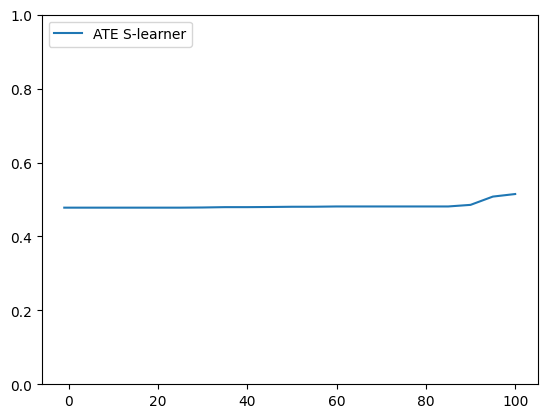

In [11]:
step = 5
bin_edges = np.arange(0, 100+step, step)
bin_edges[0] = -1
ate_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=clf, 
    modelling_features=X_train.columns, 
    feature_conterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
plt.plot(bin_edges, ate_data, label="ATE S-learner")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()

In [12]:
# linear reg
features_regression = confounders
features_regression = [c for c in X_train.columns if c not in [TREATMENT, OUTCOME]]
regression_formula_str = build_sm_regression_formula(
    outcome=OUTCOME,
    treatment=TREATMENT,
    confounders=features_regression,
    interactive_features=[]
)

print("Constructed formula:")
print(regression_formula_str)


model = smf.ols(
    formula=regression_formula_str,
    data=train
).fit()
print(model.summary())


print("Train")
get_metrics(train, y_train, model, task="regression", model_package="statsmodels")
print("")

print("Test")
get_metrics(test, y_test, model, task="regression", model_package="statsmodels")
print("")

Constructed formula:
debt_repayment_flag ~ perc_debt_forgivness + antiguedad + n_cuenta + n_consumo + years_since_default + LGD + default_debt_amount + n_tarjeta + n_refin + months_since_first_payment + debt_cirbe + redundantfeature1_n_tarjeta + redundantfeature2_LGD + redundantfeature3_default_debt_amount + redundantfeature4_n_consumo + redundantfeature5_n_refin + redundantfeature6_n_cuenta + redundantfeature7_n_tarjeta + redundantfeature8_n_consumo + redundantfeature9_months_since_first_payment + redundantfeature10_n_cuenta + redundantfeature11_n_cuenta + redundantfeature12_n_refin + redundantfeature13_n_consumo + redundantfeature14_default_debt_amount + redundantfeature15_n_refin + redundantfeature16_debt_repayment_flag_probs + redundantfeature17_n_refin + redundantfeature18_n_refin + redundantfeature19_debt_cirbe + redundantfeature20_n_tarjeta + redundantfeature21_years_since_default + redundantfeature22_antiguedad + redundantfeature23_n_refin + redundantfeature24_LGD + redundantfe